## Twitter Sentiment Analysis


* Data Source: https://www.kaggle.com/kazanova/sentiment140

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

Content

* It contains the following 6 fields:

* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)


#### Imports

* The main python packages that are used are: 
    * `NLTK` and regular expresions for input text manipulations
    * `Keras/TensorFlow` to train the MLP classifier
    * `Pandas` and `Matplotlib` to depict results

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import nltk
nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords

#from nltk.corpus import reuters
#from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  

#from keras.utils import np_utils # Utilities to manipulate numpy arrays

# plots
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giorgosfat17/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data
file = "training.1600000.processed.noemoticon.csv"
cols = ['target','id','date','flag','user','text']
df = pd.read_csv(file,encoding =  "ISO-8859-1",header=None, names=cols)

# 0 for positive / 1 for negative
df['target'] = (df['target']==4).astype(int)

y = np.array(df.target)
X  = list(df.text)

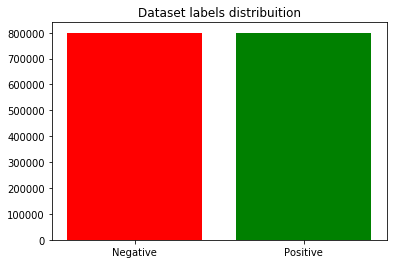

In [3]:
# Count the number of entities in each category
target_cnt = Counter(df.target)
plt.figure(figsize=(6,4))
plt.bar(target_cnt.keys(), target_cnt.values(),tick_label =('Negative', 'Positive'),color=['r','g'])
plt.title("Dataset labels distribuition")
plt.show()

* From the above plot it can be seen that the dataset is balanced. We have 8000,000 positive and and negative tweets.

Each tweet has the following format:

In [4]:
df.text[45]

"@Viennah Yay! I'm happy for you with your job! But that also means less time for me and you... "

#### Preprocessing

* We will remove from each tweet special characters, single characters, multiple spaces and prefixed letters and prefix such as '@nickname'.
* Everything will be converted to Lowercase.
* Using the WordNet Lemmatizer we will keep the stem of each word (only for words in the WordNet).

After preprocessing the above emails is transformed to:

In [5]:
tweets = []
for i in range(len(X)):
    
    tweet = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(X[i]))
    
    # remove all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    
    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    
    # Converting to Lowercase
    tweet = tweet.lower()

    # Lemmatization
    tweet = tweet.split()

    tweet = [stemmer.lemmatize(word) for word in tweet]
    tweet = ' '.join(tweet)
    tweets.append(tweet)

In [6]:
tweets[45]

'yay m happy for you with your job but that also mean le time for me and you'

#### Split dataset into train (70%) & development(10%) & test (30%)

* Due to the large number of available data (1,600,000) we will do our analysis in a random 10% sample, in order to speed up computations. (Use of all the data did not impove the accuracy of the classifier)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.3, random_state=23828748)
# keep only the 20%
X_train,X_dev, X_test, y_train,y_dev, y_test = X_train[:160000],X_test[:32000], X_test[32000:96000], y_train[:160000], y_test[:32000],y_test[32000:96000]

#### Feature extraction (Tf*IDF n-gram features)

* In order to perform the classification (positive/negative) among the tweets, we represent them as `bags of words/ngrams`.
* We build features using the TF*IDF score of single words and bigrams.

    * TF: how frequent each vocabulary word is in the given tweet. 
    * IDF: how rare each word of an tweet is in the language.
    
* Each tweet is transformed in a TF*IDF vector with length same as the number of the features. Thus, most values of this vector will be 0, as only a few of all the features will be present in a given tweet.

* After removing the stop-words, we extract as features the 10000 words/bigrams with the highest frequency across the corpus.

In [43]:
#Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(max_features=10000,stop_words=stopwords.words('english'))

x_train = vectorizer.fit_transform(X_train)
x_dev  = vectorizer.transform(X_dev)
x_test = vectorizer.transform(X_test)

In [9]:
# Define evaluation metrics
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

### MLP classifier in Keras using tf*idf features

We use a Sequential Model with following layers:
    
- `Input` layer with dimentions [10000x1]
- ` Dense layer` with 64 nodes and ReLu as activiation function.
    - `Dropout` 30%
- ` Dense layer` with 64 nodes and ReLu as activiation function.
    - `Dropout` 30%
- `Dense Layer` with output 1 node and Sigmoid activiation function..
    - `Dropout` 25%

To compile the model:
- As optimazer we use `Adam`.
- As loss function we use `binary_crossentropy`.


To evaluate the model:
- F1-Score is used.


In [ ]:
!pip install keras-tqdm

In [12]:
# to run tensorflow on mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [44]:
#import warnings
#import sklearn.exceptions
#warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
#warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1] , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,  activation='sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

earlystopping=EarlyStopping(monitor='val_f1', patience=2, verbose=1)
                   
                  

history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,earlystopping,TQDMNotebookCallback()],
              validation_data=(x_dev, y_dev),
              shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76378, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76378 to 0.76613, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76613



Epoch 00004: val_f1 did not improve from 0.76613



Epoch 00005: val_f1 did not improve from 0.76613



Epoch 00006: val_f1 did not improve from 0.76613



Epoch 00007: val_f1 did not improve from 0.76613



Epoch 00008: val_f1 did not improve from 0.76613



Epoch 00009: val_f1 did not improve from 0.76613



Epoch 00010: val_f1 did not improve from 0.76613



#### Results on the development set

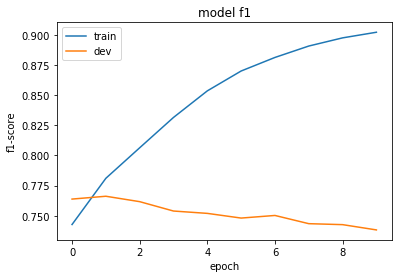

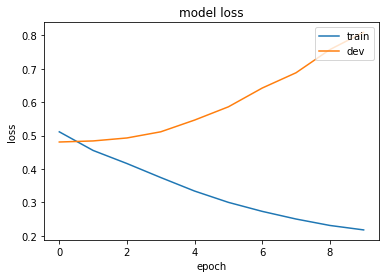

In [45]:
# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

* From the above results it can be seen that our model learns the weights of the network very quickly, resulting to overfitting after the 2nd epoch.

#### Results on the unseen Test set

In [15]:
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1] , activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
#load weights from the pre-trained model
model.load_weights("keras_tf_idf_model")
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

score = model.evaluate(
    x_test,
    y_test,          
    batch_size=32,
    verbose=1)


print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
print('\nTest precision: %.4f' %  (score[1]))
print('\nTest recall: %.4f' %  (score[2]))
print('\nTest f1: %.4f' % (score[3]))
print('\nTest accuracy: %.4f'% (score[4]))

64000/64000 [==============================] - 4s 70us/step

Test Binary_cross_entropy: 0.4851

Test precision: 0.7505

Test recall: 0.7953

Test f1: 0.7667

Test accuracy: 0.7655


In [16]:
predictions = model.predict(x_test)
predictions = predictions.reshape(len(predictions),)

for i in range(len(predictions)):
    if predictions[i]<0.5:
        predictions[i]=0
    else:
        predictions[i]=1

y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions, name='Predicted')
pd.crosstab(y_true, y_pred)

Predicted,0.0,1.0
True,,
0,23467,8455
1,6552,25526


### Types of mistakes that MLP classifier makes.

In [47]:
for i in range(30):
    if y_true[i]!= y_pred[i]:
        print("Preprocessed Tweet:",X_test[i] )
        print("Predicted probability:",model.predict(x_test[i]))
        print("True Value:",y_true[i] )
        print("------------------------------------------------")

Preprocessed Tweet: listening to ciccilleju quot martina quot brings me so many memory 2004 nostalgia even candytron by kb kick in am that old already
Predicted probability: [[0.9959235]]
True Value: 0
------------------------------------------------
Preprocessed Tweet: had late dinner too it 4 05am here now though and cant sleep gt lt whats the time where you are
Predicted probability: [[0.00452049]]
True Value: 1
------------------------------------------------
Preprocessed Tweet: i think understand why people don walk around la now it not because it spread out it cause it so ugly
Predicted probability: [[0.15586983]]
True Value: 1
------------------------------------------------
Preprocessed Tweet: m ninja tized gangster be jealous
Predicted probability: [[0.10243633]]
True Value: 1
------------------------------------------------
Preprocessed Tweet: depends if you follow people to get them to follow back or because you like to hear the buzz loved track but must follow now
Predicted

### Hyperparameter fine-tuning

* We fine-tune only a fews parameters of the MLP classifier due to lack of computational resources. Those parameters are:
    * nodes = [64, 128, 256]
    * dropout = [0.1, 0.2, 0.3]
    * epochs = [2, 3, 4]


In [18]:
nodes = [64, 128, 256]
dropouts = [0.1, 0.2, 0.3]
epochs = [2, 3, 4]
histories = []

for node1 in nodes:
    for node2 in nodes:
        for dropout in dropouts:
            for epoch in epochs:
                if node1>=node2:
                    model = Sequential()
                    model.add(Dense(node1, input_dim=x_train.shape[1] , activation='relu'))
                    model.add(Dropout(dropout))
                    model.add(Dense(node2, activation='relu'))
                    model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))
                    print(model.summary())
                    model.compile(loss='binary_crossentropy',
                                  optimizer=Adam(lr=0.001),
                                  metrics=[precision, recall, f1, accuracy])
                    checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
                    earlystopping=EarlyStopping(monitor='val_f1', patience=2, verbose=1)
                    history = model.fit(x_train, y_train,
                                        batch_size=32,
                                        epochs=epoch,
                                        verbose = 0,
                                        callbacks=[checkpoint,earlystopping,TQDMNotebookCallback()],
                                        validation_data=(x_dev, y_dev),
                                        shuffle=True)
                    histories.append([2, node1, node2, 0, dropout, epoch, history.history['val_f1'][-1]])

for node1 in nodes:
    for node2 in nodes:
        for node3 in nodes:
            for dropout in dropouts:
                for epoch in epochs:
                    if node1>=node2 and node2>=node3:
                        model = Sequential()
                        model.add(Dense(node1, input_dim=x_train.shape[1] , activation='relu'))
                        model.add(Dropout(dropout))
                        model.add(Dense(node2, activation='relu'))
                        model.add(Dropout(dropout))
                        model.add(Dense(node2, activation='relu'))
                        model.add(Dropout(dropout))
                        model.add(Dense(1, activation='sigmoid'))
                        print(model.summary())
                        model.compile(loss='binary_crossentropy',
                                      optimizer=Adam(lr=0.001),
                                      metrics=[precision, recall, f1, accuracy])
                        checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
                        earlystopping=EarlyStopping(monitor='val_f1', patience=2, verbose=1)
                        history = model.fit(x_train, y_train,
                                            batch_size=32,
                                            epochs=epoch,
                                            verbose = 0,
                                            callbacks=[checkpoint,earlystopping,TQDMNotebookCallback()],
                                            validation_data=(x_dev, y_dev),
                                            shuffle=True)
                        histories.append([3, node1, node2, node3, dropout, epoch, history.history['val_f1'][-1]])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75827, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.75827

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75638, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75638 to 0.75745, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.75745
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76124, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76124 to 0.76582, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76582



Epoch 00004: val_f1 did not improve from 0.76582

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76748, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76748

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75401, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75401 to 0.76233, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.76233 to 0.76466, saving model to keras_tf_idf_model
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76678, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76678 to 0.76828, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76828



Epoch 00004: val_f1 did not improve from 0.76828

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75887, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75887 to 0.76775, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75177, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75177 to 0.76038, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76038
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76557, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76557



Epoch 00003: val_f1 did not improve from 0.76557



Epoch 00004: val_f1 did not improve from 0.76557

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76889, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76889

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76357, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76357 to 0.76673, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76673

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76009, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76009 to 0.76724, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76724



Epoch 00004: val_f1 did not improve from 0.76724

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75949, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75949 to 0.76664, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76442, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76442 to 0.76723, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76723
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76934, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76934



Epoch 00003: val_f1 did not improve from 0.76934



Epoch 00004: val_f1 did not improve from 0.76934

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76249, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76249

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76536, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76536 to 0.76571, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.76571 to 0.76647, saving model to keras_tf_idf_model
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76387, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76387



Epoch 00003: val_f1 did not improve from 0.76387



Epoch 00004: val_f1 did not improve from 0.76387

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76484, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76484 to 0.76701, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76689, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76689 to 0.77160, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77160

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76662, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76662



Epoch 00003: val_f1 did not improve from 0.76662



Epoch 00004: val_f1 did not improve from 0.76662

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76865, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76865

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76961, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76961



Epoch 00003: val_f1 did not improve from 0.76961

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76248, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76248 to 0.76882, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76882



Epoch 00004: val_f1 did not improve from 0.76882

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75768, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75768 to 0.77100, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76497, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76497 to 0.76732, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76732

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76352, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76352



Epoch 00003: val_f1 improved from 0.76352 to 0.76378, saving model to keras_tf_idf_model



Epoch 00004: val_f1 did not improve from 0.76378

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76969, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76969

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76436, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76436 to 0.76932, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76932

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_64 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76527, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76527



Epoch 00003: val_f1 did not improve from 0.76527



Epoch 00004: val_f1 did not improve from 0.76527

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_66 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75721, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75721 to 0.76843, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_68 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75909, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75909 to 0.76926, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76926
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_70 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76491, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76491 to 0.76853, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76853



Epoch 00004: val_f1 did not improve from 0.76853

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_72 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76498, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76498

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76548, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76548 to 0.76817, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76817

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75510, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75510 to 0.76972, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76972
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76707, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76707

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_80 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75195, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75195 to 0.77330, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77330

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_82 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76060, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76060 to 0.76758, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76758
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_84 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76490, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76490 to 0.76561, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_134 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_86 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76171, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76171 to 0.76966, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76966

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_87 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_88 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76132, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76132 to 0.76869, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76869



Epoch 00004: val_f1 did not improve from 0.76869

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_89 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_90 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76649, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76649

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_91 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_92 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76262, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76262 to 0.76839, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76839
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_93 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_94 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76503, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76503



Epoch 00003: val_f1 did not improve from 0.76503



Epoch 00004: val_f1 did not improve from 0.76503

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_95 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_96 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76636, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76636 to 0.76953, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_97 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_98 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76756, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76756



Epoch 00003: val_f1 did not improve from 0.76756

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_99 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_100 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75466, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75466 to 0.76951, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76951
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_102 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76107, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76107

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_103 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_104 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76626, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76626



Epoch 00003: val_f1 did not improve from 0.76626

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_105 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_106 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76237, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76237 to 0.76333, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76333



Epoch 00004: val_f1 did not improve from 0.76333

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_108 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76291, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76291 to 0.76832, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_109 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_110 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75566, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75566 to 0.76703, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76703
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_111 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_112 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75993, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75993 to 0.76254, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76254



Epoch 00004: val_f1 did not improve from 0.76254

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_114 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_115 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_178 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75679, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.75679

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_117 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_118 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_182 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.77079, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.77079



Epoch 00003: val_f1 did not improve from 0.77079

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_119 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_184 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_120 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_121 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_186 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76680, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76680



Epoch 00003: val_f1 did not improve from 0.76680



Epoch 00004: val_f1 did not improve from 0.76680

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_122 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_188 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_123 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_124 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_190 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75194, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75194 to 0.75838, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_125 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_126 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_127 (Dropout)        (None, 64)                0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75846, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75846 to 0.76333, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76333
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_128 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_196 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_129 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_130 (Dropout)        (None, 64)                0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76500, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76500 to 0.76694, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76694



Epoch 00004: val_f1 did not improve from 0.76694

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_131 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_200 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_132 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_133 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_202 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76545, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76545

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_134 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_135 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_136 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_206 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76209, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76209 to 0.76657, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76657

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 64)                640064    
_________________________________________________________________
dropout_137 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_208 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_138 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_139 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_210 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76358, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76358 to 0.76721, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76721



Epoch 00004: val_f1 did not improve from 0.76721

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_140 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_212 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_141 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_142 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_214 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76369, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76369 to 0.76407, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_143 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_144 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_217 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_145 (Dropout)        (None, 64)                0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76522, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76522



Epoch 00003: val_f1 did not improve from 0.76522

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_146 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_147 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_148 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_222 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75872, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75872 to 0.76741, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76741
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_149 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_150 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_151 (Dropout)        (None, 64)                0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.74720, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.74720 to 0.75959, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_227 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_152 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_228 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_153 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_154 (Dropout)        (None, 64)                0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.77014, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.77014



Epoch 00003: val_f1 did not improve from 0.77014

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_155 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_232 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_156 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_157 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_234 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76478, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76478 to 0.76593, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76593



Epoch 00004: val_f1 did not improve from 0.76593

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_158 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_159 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_237 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_160 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_238 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76150, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76150

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_239 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_161 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_162 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_163 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_242 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75695, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75695 to 0.77128, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77128

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_243 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_164 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_244 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_165 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_245 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_166 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_246 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75471, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75471 to 0.77013, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77013
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_247 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_167 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_168 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_249 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_169 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75975, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75975 to 0.76356, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_170 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_252 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_171 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_253 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_172 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75131, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75131 to 0.77151, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77151
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_173 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_256 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_174 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_257 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_175 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75607, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75607 to 0.76020, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76020



Epoch 00004: val_f1 did not improve from 0.76020

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_176 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_260 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_177 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_178 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_262 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76685, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76685 to 0.76761, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_179 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_180 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_181 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76499, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76499



Epoch 00003: val_f1 did not improve from 0.76499

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_267 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_182 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_268 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_183 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_269 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_184 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_270 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76389, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76389 to 0.76947, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76947



Epoch 00004: val_f1 did not improve from 0.76947

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_185 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_272 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_186 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_273 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_187 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_274 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76491, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76491

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_275 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_188 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_276 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_189 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_277 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_190 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_278 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76573, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76573 to 0.77153, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77153

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_191 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_192 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_193 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_282 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76325, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76325 to 0.76560, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76560



Epoch 00004: val_f1 did not improve from 0.76560

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_283 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_194 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_284 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_195 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_285 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_196 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_286 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75906, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75906 to 0.76353, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_287 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_197 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_288 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_198 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_289 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_199 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75605, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75605 to 0.75761, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.75761

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_200 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_292 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_201 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_293 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_202 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_294 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76123, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76123 to 0.76756, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76756



Epoch 00004: val_f1 did not improve from 0.76756

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_295 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_203 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_296 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_204 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_205 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_298 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76049, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76049 to 0.76385, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_299 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_206 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_300 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_207 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_301 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_208 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.74886, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.74886 to 0.76528, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76528
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_209 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_210 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_305 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_211 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75434, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75434 to 0.76558, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76558



Epoch 00004: val_f1 did not improve from 0.76558

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_307 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_212 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_308 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_213 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_214 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_310 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76843, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76843

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_311 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_215 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_312 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_216 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_217 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_314 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76469, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76469 to 0.76613, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76613

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dropout_218 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_316 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_219 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_220 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_318 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75703, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.75703



Epoch 00003: val_f1 improved from 0.75703 to 0.76204, saving model to keras_tf_idf_model



Epoch 00004: val_f1 did not improve from 0.76204

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_319 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_221 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_320 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_222 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_321 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_223 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_322 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75472, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75472 to 0.76744, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_323 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_224 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_324 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_225 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_226 (Dropout)        (None, 64)                0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75364, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75364 to 0.77124, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77124
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_327 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_227 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_328 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_228 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_229 (Dropout)        (None, 64)                0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76587, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76587 to 0.77016, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77016



Epoch 00004: val_f1 did not improve from 0.77016

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_230 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_332 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_231 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_333 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_232 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_334 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76675, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76675 to 0.76777, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_233 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_234 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_337 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_235 (Dropout)        (None, 64)                0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76632, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76632



Epoch 00003: val_f1 did not improve from 0.76632

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_339 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_236 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_340 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_237 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_341 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_238 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_342 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75855, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75855 to 0.76361, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76361
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_343 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_239 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_344 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_240 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_345 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_241 (Dropout)        (None, 64)                0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76035, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76035

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_347 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_242 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_348 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_243 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_349 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_244 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_350 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76008, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76008 to 0.76452, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76452
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_245 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_246 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_353 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_247 (Dropout)        (None, 64)                0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75917, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75917 to 0.76839, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76839
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_248 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_356 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_249 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_357 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_250 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76185, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76185 to 0.76900, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_359 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_251 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_360 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_252 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_253 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76826, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76826



Epoch 00003: val_f1 did not improve from 0.76826

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_363 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_254 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_364 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_255 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_256 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_366 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76568, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76568 to 0.76803, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76803



Epoch 00004: val_f1 did not improve from 0.76803

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_257 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_368 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_258 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_369 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_259 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_370 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76574, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76574 to 0.77053, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_371 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_260 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_372 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_261 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_373 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_262 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75999, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75999 to 0.76366, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76366

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_375 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_263 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_376 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_264 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_377 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_265 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_378 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76345, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76345 to 0.76635, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76635



Epoch 00004: val_f1 did not improve from 0.76635

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_379 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_266 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_380 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_267 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_381 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_268 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_382 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76257, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76257 to 0.76814, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_383 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_269 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_384 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_270 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_385 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_271 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75378, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75378 to 0.76777, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76777
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_387 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_272 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_388 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_273 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_389 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_274 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76673, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76673



Epoch 00003: val_f1 did not improve from 0.76673



Epoch 00004: val_f1 did not improve from 0.76673

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_391 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_275 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_392 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_276 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_393 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_277 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_394 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76262, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76262

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_395 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_278 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_396 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_279 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_397 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_280 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_398 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76473, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76473 to 0.76526, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76526

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_399 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_281 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_400 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_282 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_401 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_283 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_402 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75738, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75738 to 0.77072, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77072



Epoch 00004: val_f1 did not improve from 0.77072

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_403 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_284 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_404 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_285 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_405 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_286 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_406 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76466, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76466 to 0.77199, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_407 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_287 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_408 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_288 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_409 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_289 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75195, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75195 to 0.76667, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76667

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_411 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_290 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_412 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_291 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_413 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_292 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_414 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75917, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75917 to 0.76398, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76398
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_415 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_293 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_416 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_294 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_417 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_295 (Dropout)        (None, 128)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76553, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76553 to 0.77017, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_419 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_296 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_420 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_297 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_421 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_298 (Dropout)        (None, 128)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76247, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76247 to 0.76469, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76469

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_423 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_299 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_424 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_300 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_425 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_301 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_426 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76812, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76812



Epoch 00003: val_f1 did not improve from 0.76812



Epoch 00004: val_f1 did not improve from 0.76812

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_427 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_302 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_428 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_303 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_429 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_304 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_430 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75985, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75985 to 0.76020, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_431 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_305 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_432 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_306 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_433 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_307 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76885, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76885 to 0.76984, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76984

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_435 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_308 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_436 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_309 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_437 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_310 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_438 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76646, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76646



Epoch 00003: val_f1 did not improve from 0.76646



Epoch 00004: val_f1 did not improve from 0.76646

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_439 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_311 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_440 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_312 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_441 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_313 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_442 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76029, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76029 to 0.76969, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_443 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_314 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_444 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_315 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_445 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_316 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76298, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76298 to 0.76836, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76836

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_447 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_317 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_448 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_318 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_449 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_319 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_450 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76223, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76223 to 0.76832, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76832



Epoch 00004: val_f1 did not improve from 0.76832

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_320 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_452 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_321 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_453 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_322 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_454 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75078, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75078 to 0.76972, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_455 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_323 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_456 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_324 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_457 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_325 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75279, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75279 to 0.76877, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76877
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_459 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_326 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_460 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_327 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_461 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_328 (Dropout)        (None, 256)               0         
_______________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.75264, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75264 to 0.75947, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.75947 to 0.76030, saving model to keras_tf_idf_model
Epoch 00003: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_463 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_329 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_464 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_330 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_465 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_331 (Dropout)        (None, 256)               0         
_______________________


Epoch 00001: val_f1 improved from -inf to 0.75990, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75990 to 0.76088, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_467 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_332 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_468 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_333 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_469 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_334 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76122, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76122 to 0.76565, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76565

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_471 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_335 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_472 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_336 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_473 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_337 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_474 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76190, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76190



Epoch 00003: val_f1 did not improve from 0.76190



Epoch 00004: val_f1 did not improve from 0.76190

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_475 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_338 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_476 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_339 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_477 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_340 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_478 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76497, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76497

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_479 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_341 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_480 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_342 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_481 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_343 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_482 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76260, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76260 to 0.76767, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76767

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_483 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_344 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_484 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_345 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_485 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_346 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_486 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76495, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76495 to 0.77021, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77021



Epoch 00004: val_f1 did not improve from 0.77021

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_487 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_347 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_488 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_348 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_489 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_349 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_490 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.74392, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.74392 to 0.76204, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_491 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_350 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_492 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_351 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_493 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_352 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76442, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76442 to 0.76582, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76582

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_495 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_353 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_496 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_354 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_497 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_355 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_498 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76960, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76960



Epoch 00003: val_f1 did not improve from 0.76960



Epoch 00004: val_f1 did not improve from 0.76960

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_499 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_356 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_500 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_357 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_501 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_358 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_502 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76979, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76979

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_503 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_359 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_504 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_360 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_505 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_361 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_506 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75492, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75492 to 0.76338, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76338

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_507 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_362 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_508 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_363 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_509 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_364 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_510 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76228, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76228



Epoch 00003: val_f1 did not improve from 0.76228



Epoch 00004: val_f1 did not improve from 0.76228

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_511 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_365 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_512 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_366 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_513 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_367 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_514 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76320, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76320 to 0.76469, saving model to keras_tf_idf_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_515 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_368 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_516 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_369 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_517 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_370 (Dropout)        (None, 256)               0         
___________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.76276, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76276 to 0.76368, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76368

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_519 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_371 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_520 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_372 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_521 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_373 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_522 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76657, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76657



Epoch 00003: val_f1 did not improve from 0.76657



Epoch 00004: val_f1 did not improve from 0.76657

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_523 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_374 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_524 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_375 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_525 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_376 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_526 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76167, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76167

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_527 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_377 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_528 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_378 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_529 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_379 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_530 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.76700, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76700 to 0.76752, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76752

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_531 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dropout_380 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_532 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_381 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_533 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_382 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_534 (Dense)        


Epoch 00001: val_f1 improved from -inf to 0.75199, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75199 to 0.76602, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76602
Epoch 00003: early stopping



In [56]:
cols = ['No of Hidden Layers','Nodes in Layer 1','Nodes in Layer 2','Nodes in Layer 3','Dropout','Epochs','F1 Score %']
df1 = pd.DataFrame(data = histories,columns=cols)
print('The 10 best combinations of parameters')
df1['F1 Score %'] = round(df1['F1 Score %']*100,2)
df1.sort_values(by='F1 Score %',ascending=False).head(10)

The 10 best combinations of parameters


,No of Hidden Layers,Nodes in Layer 1,Nodes in Layer 2,Nodes in Layer 3,Dropout,Epochs,F1 Score %
111,3,256,128,128,0.2,2,77.20
24,2,128,128,0,0.3,2,77.10
102,3,256,128,64,0.2,2,77.05
114,3,256,128,128,0.3,2,77.02
120,3,256,256,64,0.2,2,76.97
123,3,256,256,64,0.3,2,76.97
45,2,256,256,0,0.1,2,76.95
99,3,256,128,64,0.1,2,76.90
30,2,256,64,0,0.2,2,76.84
51,2,256,256,0,0.3,2,76.83


In [58]:
print('The 10 worst combinations of parameters')
df1.sort_values(by='F1 Score %',ascending=False).tail(10)

The 10 worst combinations of parameters


,No of Hidden Layers,Nodes in Layer 1,Nodes in Layer 2,Nodes in Layer 3,Dropout,Epochs,F1 Score %
50,2,256,256,0,0.2,4,74.79
104,3,256,128,64,0.2,4,74.76
29,2,256,64,0,0.1,4,74.54
74,3,128,128,64,0.1,4,74.52
110,3,256,128,128,0.1,4,74.41
136,3,256,256,256,0.1,3,74.34
131,3,256,256,128,0.2,4,74.17
101,3,256,128,64,0.1,4,74.06
119,3,256,256,64,0.1,4,73.94
137,3,256,256,256,0.1,4,72.88
